370
320


c:\users\nb-smilovic\envs\iiasa\lib\site-packages\pykrige\kriging_tools.py:69: RuntimeWarning: Order of X or Y coordinates is not as expected. Incorrect *.asc file generation may result.
  warnings.warn(


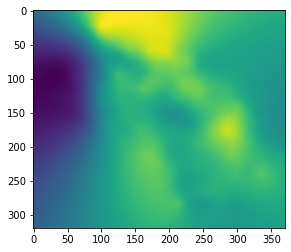

In [1]:
import numpy as np
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
import xlrd
import netCDF4 as nc4

groundwaterObservationsLocation = 'C:\GitHub\FUSE\Data_forNotebooks\WaterTable\\'

wb = xlrd.open_workbook(groundwaterObservationsLocation+'UB_GW_Data_kriging.xls')
sheet = wb.sheet_by_index(0)

X=[]
Y=[]
Z_wet=[]
Z_dry=[]
Z_depth_wet=[]
Z_depth_dry=[]

for i in range(1, sheet.nrows):
    X.append(sheet.cell_value(i, 4))
    Y.append(sheet.cell_value(i, 3))
    Z_wet.append(sheet.cell_value(i, 5) - sheet.cell_value(i, 7))
    Z_depth_wet.append(sheet.cell_value(i, 7))
    Z_dry.append(sheet.cell_value(i, 5) - sheet.cell_value(i, 19))
    Z_depth_dry.append(sheet.cell_value(i, 19))

X = np.array(X)
Y = np.array(Y)
Z_dry = np.array(Z_dry)
Z_wet = np.array(Z_wet)
Z_depth_dry = np.array(Z_depth_dry)
Z_depth_wet = np.array(Z_depth_wet)

gridx = np.arange(73.1708, 76.24583+0.0083, 0.0083333333333333333333)
gridy = np.arange(19.49583, 16.83750-0.0083, -0.0083333333333333333333)

###############################################################################
# Create the ordinary kriging object. Required inputs are the X-coordinates of
# the data points, the Y-coordinates of the data points, and the Z-values of the
# data points. If no variogram model is specified, defaults to a linear variogram
# model. If no variogram model parameters are specified, then the code automatically
# calculates the parameters by fitting the variogram model to the binned
# experimental semivariogram. The verbose kwarg controls code talk-back, and
# the enable_plotting kwarg controls the display of the semivariogram.

for Z in [Z_depth_wet]: #, Z_wet, Z_wet-Z_dry][0]:
    OK = OrdinaryKriging(
        X,
        Y, 
        Z,
        variogram_model="linear",
        verbose=False,
        enable_plotting=False,
        #coordinates_type="geographic"
    )

    z, ss = OK.execute("grid", gridx, gridy)

    print(len(z[0])) #xaxis 370
    print(len(z)) #yaxis 320
    kt.write_asc_grid(gridx, gridy, z, filename="output.asc")
    plt.imshow(z)
    plt.show()

In [2]:
f2 = nc4.Dataset('GroundwaterObservationsKriged_wet_depth.nc','w', format='NETCDF4')
base = 'C:\\GitHub\FUSE\\Input\\landsurface\\albedo\\albedo_UB_1km.nc'

#base = 'C:\\Data\\bhima_Input_mainCWatM\\Input\\landsurface\\Forest_fraction.nc'
nc = nc4.Dataset(base,'r')

f2.createDimension('lon', nc.variables['lon'].shape[0])
f2.createDimension('lat', nc.variables['lat'].shape[0])

longitude = f2.createVariable('Longitude', 'f4', 'lon') #370
latitude = f2.createVariable('Latitude', 'f4', 'lat')  #320
frac = f2.createVariable('Groundwater depth', 'f4', ('lat', 'lon'), zlib=True, least_significant_digit=4)

longitude[:] = nc.variables['lon'][:]
latitude[:] = nc.variables['lat'][:]



In [3]:
for i in range(len(z)): #320
    frac[i,:] = z[i]

In [4]:
f2.close()